In [115]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from Scripts import reverse_preprocessing_func as rv
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, ParameterGrid
from skorch.regressor import NeuralNetRegressor
from Scripts import to_stationary as ts
from Scripts import dir_functions
from Scripts import metrics_plotting as mp
from Scripts import train_and_eval as train_eval
import os
import glob
import shutil
import json
import copy
from Scripts import dir_functions

torch.manual_seed(32)


In [136]:
results_folder = 'C:/Users/taina/OneDrive/Documentos/GitHub/TimeSeries-Forecasting/ONS/results/LSTM/sudeste'
models_folder = 'C:/Users/taina/OneDrive/Documentos/GitHub/TimeSeries-Forecasting/ONS/models/LSTM/sudeste'

if not os.path.exists(results_folder):
    os.mkdir(results_folder)
    
if not os.path.exists(models_folder):
    os.mkdir(models_folder)

# Import Data

In [117]:
data = pd.read_pickle('processed_curves/df_sudeste.pkl')

# Modeling

## Split into train an test

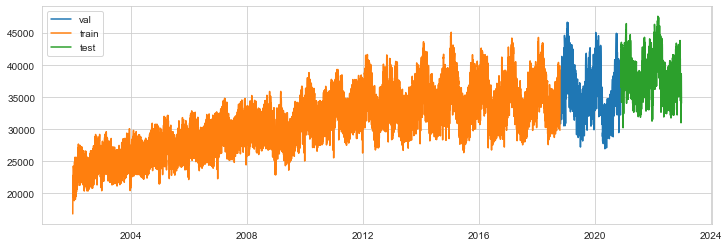

In [118]:
TEST_SIZE = 0.1
VAL_SIZE = 0.1
WINDOW_SIZE = 30

df_test = data[-round(TEST_SIZE*len(data)):]
df_train_val = data[:-round(TEST_SIZE*len(data))]
df_val = df_train_val[-round(VAL_SIZE*len(data)):]
df_train = df_train_val[:-round(VAL_SIZE*len(data))]

plt.figure(figsize=(12,4))
plt.plot(df_val.data, df_val.carga)
plt.plot(df_train.data, df_train.carga)
plt.plot(df_test.data, df_test.carga)
plt.legend(['val', 'train', 'test'])


## Prepare Dataset

In [119]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [120]:
# window_size = dimensão da entrada (quantidade de lags utilizados)
def prepare_dataset(df, window_size=30, batch_size=32):
    consumption = df['carga'].values
    date = df['data'].values
    x = []
    y = []
    y_date = []

    dim = window_size

    for i in range(len(df)-dim):
        x.append(consumption[i:i+dim])
        y.append(consumption[i+dim])
        y_date.append(date[i+dim])

    x = torch.FloatTensor(np.array(x)).reshape(-1,window_size,1)
    y = torch.FloatTensor(np.array(y)).reshape(-1,1)
    dataset = TimeSeriesDataset(x,y)
    dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return x, y, y_date, dataset_loader

## LSTM Model


In [121]:
class LSTM(nn.Module):
    def __init__(self,input_size=1, hidden_size=50, stacked_layers=1, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.stacked_layers = stacked_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, stacked_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size,output_size)
        
    def forward(self,x):
        batch_size = x.size(0)
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(self.stacked_layers, batch_size, self.hidden_size),
                       torch.zeros(self.stacked_layers, batch_size, self.hidden_size))
                
        lstm_out, _ = self.lstm(x, self.hidden)
        lstm_out = self.linear(lstm_out[:,-1,:])
        return lstm_out

    def predict(self, x):
        y_pred = []
        with torch.no_grad():
            for i,seq in enumerate(x):
                y_pred.append(np.array(self.forward(seq)))
        return np.array(y_pred)

In [122]:
params = {
    'hidden_size' : [20, 50, 100],
    'lr' : [0.005, 0.01]
}

params_grid = ParameterGrid(params)
list(params_grid)

[{'hidden_size': 20, 'lr': 0.005},
 {'hidden_size': 20, 'lr': 0.01},
 {'hidden_size': 50, 'lr': 0.005},
 {'hidden_size': 50, 'lr': 0.01},
 {'hidden_size': 100, 'lr': 0.005},
 {'hidden_size': 100, 'lr': 0.01}]

In [126]:
def save_results(results_path, metrics_dict, df_denorm_test_pred, best_model):
    dir_functions.create_results_folder(results_path)
    torch.save(best_model, results_path + '/best_model.pth')
    df_denorm_test_pred.to_pickle( results_path + '/predicted.pkl')
    with open(results_path + "/metrics.json", "w") as outfile:
        json.dump(metrics_dict, outfile)

    plt.figure(figsize=(5,5))
    sns.boxplot(y = metrics_dict['mape_list'])
    sns.stripplot(y = metrics_dict['mape_list'], color = 'black')
    plt.savefig('boxplot', dpi=300)

# Running different datasets

## 1 - Normalized series

### Apply normalization

In [60]:
df_test_norm = ts.normalize(df_test)
df_train_norm = ts.normalize(df_train)
df_val_norm = ts.normalize(df_val)
df_train_val_norm = ts.normalize(df_train_val)

x_train, y_train, y_train_date, train_loader = prepare_dataset(df_train_norm, 30, batch_size=len(df_train_norm))
x_test, y_test, y_test_date,  test_loader =  prepare_dataset(df_test_norm, 30, batch_size=len(df_test_norm))
x_val, y_val, y_val_date, val_loader = prepare_dataset(df_val_norm, 30, batch_size=len(df_val_norm))
x_train_val, y_train_val, y_train_val_date, train_val_loader = prepare_dataset(df_train_val_norm, 30, batch_size=len(df_val_norm))

x_train.shape, x_test.shape, y_train.shape, y_test.shape , x_train_val.shape

(torch.Size([6096, 30, 1]),
 torch.Size([736, 30, 1]),
 torch.Size([6096, 1]),
 torch.Size([736, 1]),
 torch.Size([6862, 30, 1]))

### Hyperparameter tuning

lr = 0.005, hidden_size = 20, min val mse epoch = 18, min val MSE = 0.13190397165113205, min val MAPE = 0
lr = 0.01, hidden_size = 20, min val mse epoch = 20, min val MSE = 0.12954947169414188, min val MAPE = 0
lr = 0.005, hidden_size = 50, min val mse epoch = 20, min val MSE = 0.12455588458036128, min val MAPE = 0
lr = 0.01, hidden_size = 50, min val mse epoch = 19, min val MSE = 0.11880021837602432, min val MAPE = 0
lr = 0.005, hidden_size = 100, min val mse epoch = 20, min val MSE = 0.42546626023181705, min val MAPE = 0
lr = 0.01, hidden_size = 100, min val mse epoch = 18, min val MSE = 0.12441654949355992, min val MAPE = 0


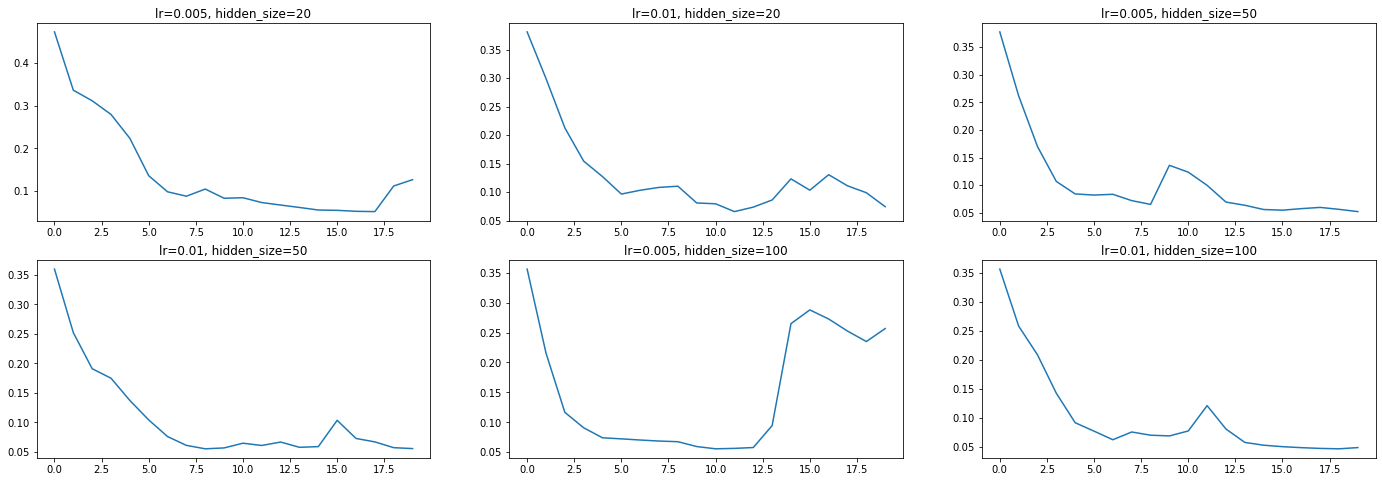

In [45]:
df_path_name = models_folder + '/df_norm'
data = {'train_loader': train_loader, 'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 
        'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date, 'df_val_norm': df_val_norm, 'val_loader': val_loader}

train_eval.training_and_tuning(data,
                    epochs=20,
                    min_epoch_eval=18,
                    df_path_name=df_path_name,
                    params_grid=params_grid,
                    plot_results=True)

### Evaluation

In [17]:
def denorm(df_test, y_test_pred, y_test_date, *args):
    df_test_pred = mp.pred_to_dataframe(y_test_pred, y_test_date)
    df_denorm_test_pred = rv.reverse_norm(df_test, df_test_pred)
    return df_denorm_test_pred

In [49]:
# best model parameters
n1 = 50
lr = 0.005

df_path_name = models_folder + '/df_norm'
data = {'df_test': df_test, 'x_test': x_test, 'y_test': y_test, 'y_test_date': y_test_date, 'df_test_norm': df_test_norm, 'df_val_norm': df_val_norm,
        'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader': train_loader, 'val_loader': val_loader}

# Run eval
best_model, metrics_dict, df_denorm_test_pred = train_eval.multiple_eval(n1, lr, data,
                                                             epochs=25,
                                                             df_path_name=df_path_name,
                                                             n_eval=20,
                                                             denorm=denorm,
                                                             min_epoch_eval=20,
                                                             verbose=True,
                                                             denorm_kwargs={})

Treino = 0, Test MAPE = 0.02635613683693979
Treino = 1, Test MAPE = 0.026872679240590374
Treino = 2, Test MAPE = 0.027891297832823306
Treino = 3, Test MAPE = 0.026426284822189557
Treino = 4, Test MAPE = 0.02737563034360607
Treino = 5, Test MAPE = 0.032650868922700305
Treino = 6, Test MAPE = 0.030648883538262485
Treino = 7, Test MAPE = 0.043944603156655805
Treino = 8, Test MAPE = 0.029356341312463834
Treino = 9, Test MAPE = 0.03361723454496772
Treino = 10, Test MAPE = 0.03983398412653568
Treino = 11, Test MAPE = 0.02948939644733951
Treino = 12, Test MAPE = 0.0282070739357647
Treino = 13, Test MAPE = 0.032708456303270815
Treino = 14, Test MAPE = 0.034286297551183724
Treino = 15, Test MAPE = 0.02723796220984078
Treino = 16, Test MAPE = 0.029892405996589783
Treino = 17, Test MAPE = 0.02748701636882622
Treino = 18, Test MAPE = 0.030326939838590052
Treino = 19, Test MAPE = 0.030670961278991212


Test
{'mse': 2502788.786913238, 'mape': 0.030670961278991212}


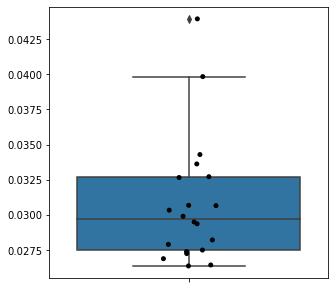

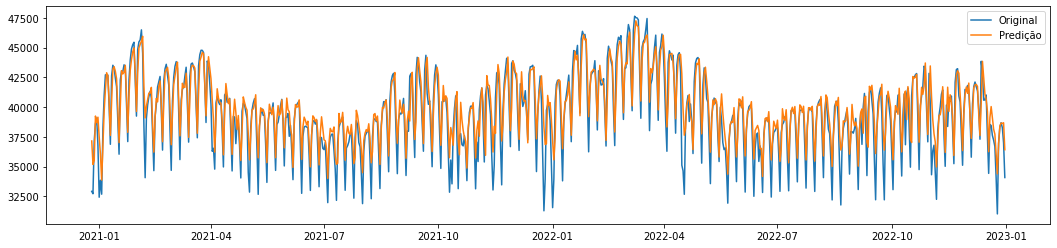

In [50]:
save_results(os.path.join(results_folder,"df_norm"), metrics_dict, df_denorm_test_pred, best_model)

mp.compare_predictions(df_test, df_denorm_test_pred)
print('Test')
print(mp.calc_metrics(df_test, df_denorm_test_pred))
#print('Train')
#print(calc_metrics(df_train, df_denorm_train_pred))

## 3 - Original series without trend by curve fitting

In [63]:
data = pd.read_pickle('processed_curves/df_sudeste.pkl')

df_test_fit, coefs_test = ts.trend_fit_curve(df_test)
df_train_fit, coefs_train = ts.trend_fit_curve(df_train)
df_val_fit, coefs_val = ts.trend_fit_curve(df_val)
data_fit, coefs_data = ts.trend_fit_curve(data)

df_test_norm = ts.normalize(df_test_fit)
df_train_norm = ts.normalize(df_train_fit)
df_val_norm = ts.normalize(df_val_fit)
data_norm = ts.normalize(data_fit)

x_train, y_train, y_train_date, train_loader = prepare_dataset(df_train_norm, 30)
x_test, y_test, y_test_date,  test_loader =  prepare_dataset(df_test_norm, 30)
x_val, y_val, y_val_date, val_loader = prepare_dataset(df_val_norm, 30)

x_train.shape, x_test.shape, y_train.shape, y_test.shape 

(torch.Size([6096, 30, 1]),
 torch.Size([736, 30, 1]),
 torch.Size([6096, 1]),
 torch.Size([736, 1]))

lr = 0.005, hidden_size = 20, min val mse epoch = 20, min val MSE = 0.1444942429171955, min val MAPE = 0
lr = 0.01, hidden_size = 20, min val mse epoch = 24, min val MSE = 0.1423158243244452, min val MAPE = 0
lr = 0.005, hidden_size = 50, min val mse epoch = 23, min val MSE = 0.14190501946786616, min val MAPE = 0
lr = 0.01, hidden_size = 50, min val mse epoch = 24, min val MSE = 0.1489219746110771, min val MAPE = 0
lr = 0.005, hidden_size = 100, min val mse epoch = 25, min val MSE = 0.14471368204367627, min val MAPE = 0
lr = 0.01, hidden_size = 100, min val mse epoch = 23, min val MSE = 0.1366863239485895, min val MAPE = 0


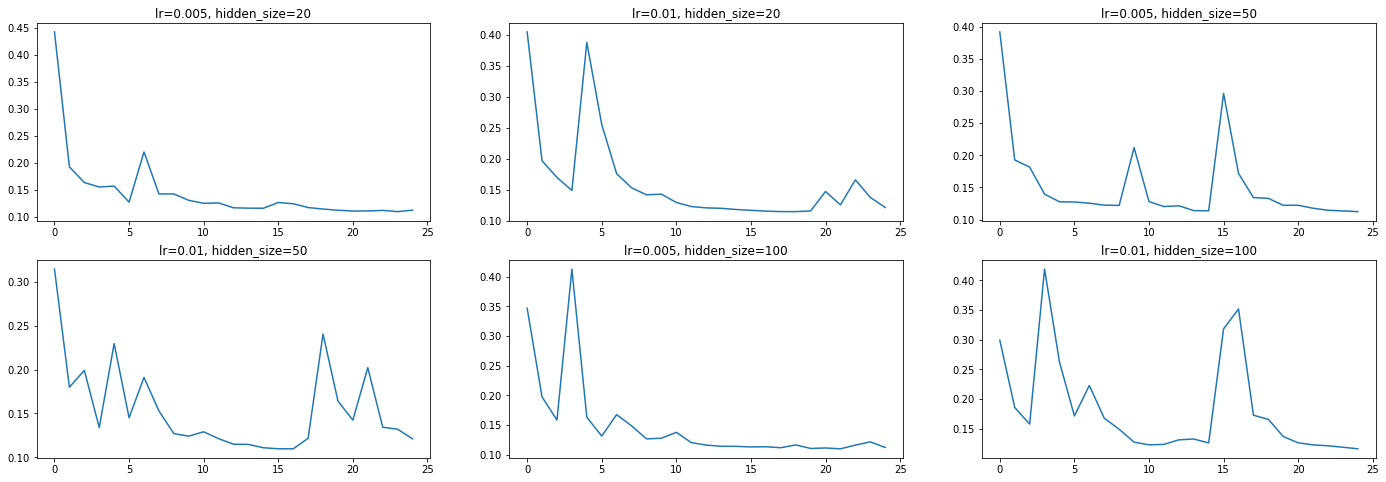

In [57]:
df_path_name = models_folder + '/df_fit_curve'
data = {'df_val_norm': df_val_norm, 'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date, 
        'train_loader': train_loader, 'val_loader': val_loader}
denorm_kwargs = {'df_train_fit': df_train_fit, 'df_test_fit': df_val_fit, 'coefs_train': coefs_train, 'coefs_test': coefs_val}

train_eval.training_and_tuning(data,
                    epochs=25,
                    min_epoch_eval=20,
                    df_path_name=df_path_name,
                    params_grid=params_grid)

In [64]:
def denorm(df_test, y_test_pred, y_test_date, *args):
    my_args = args[0]

    df_test_pred = mp.pred_to_dataframe(y_test_pred, y_test_date)
    df_trend_test_pred = rv.reverse_norm(my_args['df_test_fit'], df_test_pred)
    df_trend_test_pred = rv.reverse_trend_fit(df_trend_test_pred, my_args['coefs_test'])

    return df_trend_test_pred

In [65]:
# best model parameters
n1 = 100
lr = 0.01

df_path_name = models_folder + '/df_fit_curve'

data = {'df_test': df_test, 'x_test': x_test, 'y_test': y_test, 'y_test_date': y_test_date, 'df_test_norm': df_test_norm, 'df_val_norm': df_val_norm,
        'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date, 
        'train_loader' : train_loader, 'val_loader': val_loader}
denorm_kwargs = {'df_test_fit': df_test_fit, 'coefs_test': coefs_test}


# Run eval
best_model, metrics_dict, df_denorm_test_pred = train_eval.multiple_eval(n1, lr, data,
                                                             epochs=25,
                                                             df_path_name=df_path_name,
                                                             n_eval=20,
                                                             denorm=denorm,
                                                             min_epoch_eval=20,
                                                             verbose=True,
                                                             denorm_kwargs=denorm_kwargs)

Treino = 0, Test MAPE = 0.021050106858407112
Treino = 1, Test MAPE = 0.021553947888604846
Treino = 2, Test MAPE = 0.02221056884298109
Treino = 3, Test MAPE = 0.021793632264299746
Treino = 4, Test MAPE = 0.022264982329590868
Treino = 5, Test MAPE = 0.021802836603321007
Treino = 6, Test MAPE = 0.028953876734014717
Treino = 7, Test MAPE = 0.0206723172250212
Treino = 8, Test MAPE = 0.022005972914360586
Treino = 9, Test MAPE = 0.021820347500829756
Treino = 10, Test MAPE = 0.021102841852990887
Treino = 11, Test MAPE = 0.02171187655104422
Treino = 12, Test MAPE = 0.025918292246680085
Treino = 13, Test MAPE = 0.021920260885447282
Treino = 14, Test MAPE = 0.021096737723776574
Treino = 15, Test MAPE = 0.021589620972195366
Treino = 16, Test MAPE = 0.02129144644846253
Treino = 17, Test MAPE = 0.02222161948196013
Treino = 18, Test MAPE = 0.020482596521087165
Treino = 19, Test MAPE = 0.027221597561827206


Test
{'mse': 2311635.2949549784, 'mape': 0.027221597561827206}


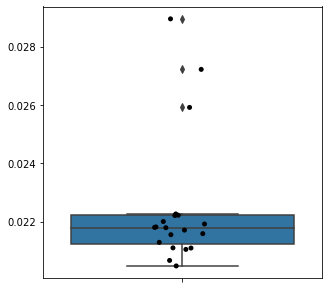

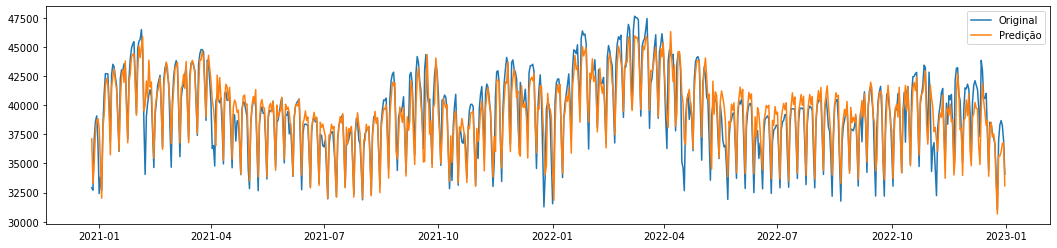

In [66]:
save_results(results_folder + '/df_fit_curve', metrics_dict, df_denorm_test_pred, best_model)

mp.compare_predictions(df_test, df_denorm_test_pred)
print('Test')
print(mp.calc_metrics(df_test, df_denorm_test_pred))

## 4 - Original series without trend by differencing

In [127]:
data = pd.read_pickle('processed_curves/df_sudeste.pkl')

df_test_diff = ts.trend_diff(df_test)
df_train_diff = ts.trend_diff(df_train)
df_val_diff = ts.trend_diff(df_val)
data_diff = ts.trend_diff(data)

df_test_norm = ts.normalize(df_test_diff)
df_train_norm = ts.normalize(df_train_diff)
df_val_norm = ts.normalize(df_val_diff)
data_norm = ts.normalize(data_diff)

x_train, y_train, y_train_date, train_loader = prepare_dataset(df_train_norm, 30)
x_test, y_test, y_test_date,  test_loader =  prepare_dataset(df_test_norm, 30)
x_val, y_val, y_val_date, val_loader = prepare_dataset(df_val_norm, 30)

lr = 0.005, hidden_size = 20, min val mse epoch = 20, min val MSE = 0.18257031708759563, min val MAPE = 0
lr = 0.01, hidden_size = 20, min val mse epoch = 25, min val MSE = 0.20039828563962933, min val MAPE = 0
lr = 0.005, hidden_size = 50, min val mse epoch = 25, min val MSE = 0.19571517011067, min val MAPE = 0
lr = 0.01, hidden_size = 50, min val mse epoch = 24, min val MSE = 0.1938179760558882, min val MAPE = 0
lr = 0.005, hidden_size = 100, min val mse epoch = 20, min val MSE = 0.18956834774088063, min val MAPE = 0
lr = 0.01, hidden_size = 100, min val mse epoch = 20, min val MSE = 0.20363751188570642, min val MAPE = 0


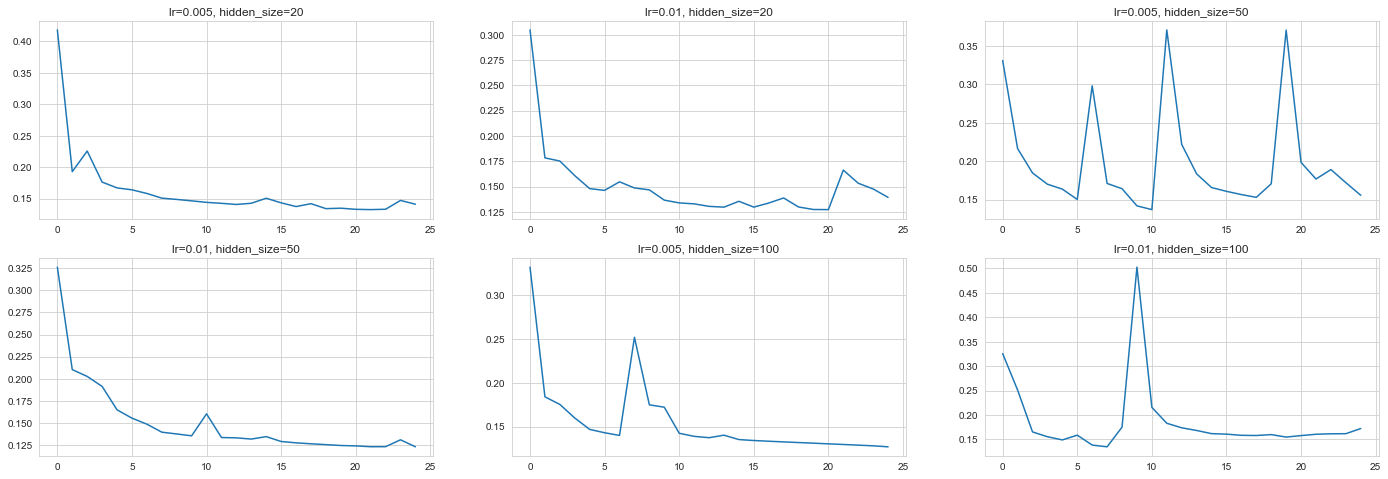

In [128]:
df_path_name = models_folder + '/df_trend_diff'
data = {'df_val_norm': df_val_norm, 'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 
        'y_val_date': y_val_date, 'train_loader': train_loader, 'val_loader': val_loader}

train_eval.training_and_tuning(data,
                    epochs=25,
                    min_epoch_eval=20,
                    df_path_name=df_path_name,
                    params_grid=params_grid)

In [129]:
def denorm(df_test, y_test_pred, y_test_date, *args):
    my_args = args[0]

    df_test_pred = mp.pred_to_dataframe(y_test_pred, y_test_date)
    df_test_pred = rv.reverse_norm(my_args['df_test_diff'], df_test_pred)
    df_test_pred = rv.reverse_trend_diff(df_test, df_test_pred)

    return df_test_pred

In [130]:
# best model parameters
n1 = 100
lr = 0.005

df_path_name = models_folder + 'df_trend_diff'
data = {'df_test': df_test, 'x_test': x_test, 'y_test': y_test, 'y_test_date': y_test_date, 'df_test_norm': df_test_norm, 'df_val_norm': df_val_norm,
        'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader':train_loader, 'val_loader':val_loader}
denorm_kwargs = {'df_train': df_train_val, 'df_test': df_val, 'df_test_diff': df_test_diff}

# Run eval
best_model, metrics_dict, df_denorm_test_pred = train_eval.multiple_eval(n1, lr, data,
                                                             epochs=25,
                                                             df_path_name=df_path_name,
                                                             n_eval=20,
                                                             denorm=denorm,
                                                             min_epoch_eval=18,
                                                             verbose=True,
                                                             denorm_kwargs=denorm_kwargs)

Treino = 0, Test MAPE = 0.021078571381198393
Treino = 1, Test MAPE = 0.01694719399632201
Treino = 2, Test MAPE = 0.017969093562614516
Treino = 3, Test MAPE = 0.01854045510422756
Treino = 4, Test MAPE = 0.019993348619662704
Treino = 5, Test MAPE = 0.01765106230069713
Treino = 6, Test MAPE = 0.01969829438620182
Treino = 7, Test MAPE = 0.020561434227248966
Treino = 8, Test MAPE = 0.017020364779456853
Treino = 9, Test MAPE = 0.017717149975915412
Treino = 10, Test MAPE = 0.017008239864905492
Treino = 11, Test MAPE = 0.018135908290859565
Treino = 12, Test MAPE = 0.017524462469185875
Treino = 13, Test MAPE = 0.034041693754361904
Treino = 14, Test MAPE = 0.01713609543873262
Treino = 15, Test MAPE = 0.01748973462981906
Treino = 16, Test MAPE = 0.017804796886583537
Treino = 17, Test MAPE = 0.01693750285652076
Treino = 18, Test MAPE = 0.018487279328112068
Treino = 19, Test MAPE = 0.018147258361957245


Test
{'mse': 1031813.3972670183, 'mape': 0.018147258361957245}


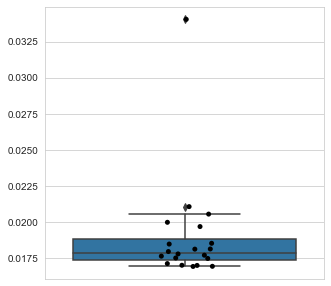

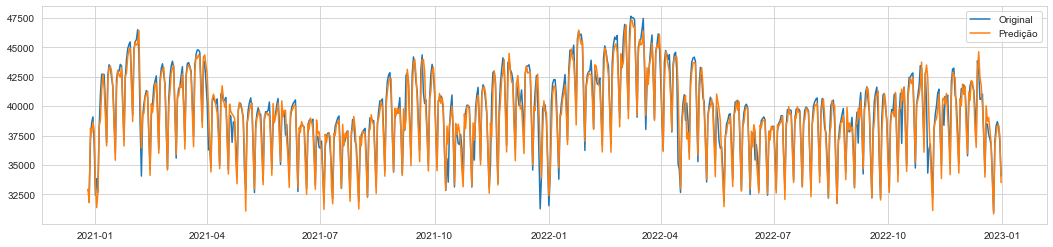

In [131]:
save_results(results_folder + '/df_trend_diff', metrics_dict, df_denorm_test_pred, best_model)

mp.compare_predictions(df_test, df_denorm_test_pred)
print('Test')
print(mp.calc_metrics(df_test, df_denorm_test_pred))

## 5 - Original series without seasonality by normalization

In [128]:
data = pd.read_pickle('processed_curves/df_sudeste.pkl')

df_test_norm, year_test_mean, year_test_std = ts.season_padronization(df_test, 'year')
df_train_norm, year_train_mean, year_train_std = ts.season_padronization(df_train, 'year')
df_val_norm, year_val_mean, year_val_std = ts.season_padronization(df_val, 'year')
data_norm, year_data_mean, year_data_std = ts.season_padronization(data, 'year')

df_test_norm, week_test_mean, week_test_std = ts.season_padronization(df_test_norm, 'week')
df_train_norm, week_train_mean, week_train_std = ts.season_padronization(df_train_norm, 'week')
df_val_norm, week_val_mean, week_val_std = ts.season_padronization(df_val_norm, 'week')
data_norm, week_data_mean, week_data_std = ts.season_padronization(data_norm, 'week')

x_train, y_train, y_train_date, train_loader = prepare_dataset(df_train_norm, 30)
x_test, y_test, y_test_date,  test_loader =  prepare_dataset(df_test_norm, 30)
x_val, y_val, y_val_date, val_loader = prepare_dataset(df_val_norm, 30)

lr = 0.005, hidden_size = 20, min val mse epoch = 19, min val MSE = 0.8697742672618692, min val MAPE = 0
lr = 0.01, hidden_size = 20, min val mse epoch = 25, min val MSE = 0.9058219031751061, min val MAPE = 0
lr = 0.005, hidden_size = 50, min val mse epoch = 23, min val MSE = 0.9102223364779777, min val MAPE = 0
lr = 0.01, hidden_size = 50, min val mse epoch = 25, min val MSE = 0.9658769267022272, min val MAPE = 0
lr = 0.005, hidden_size = 100, min val mse epoch = 25, min val MSE = 0.9465337504200622, min val MAPE = 0
lr = 0.01, hidden_size = 100, min val mse epoch = 24, min val MSE = 0.932554469063325, min val MAPE = 0


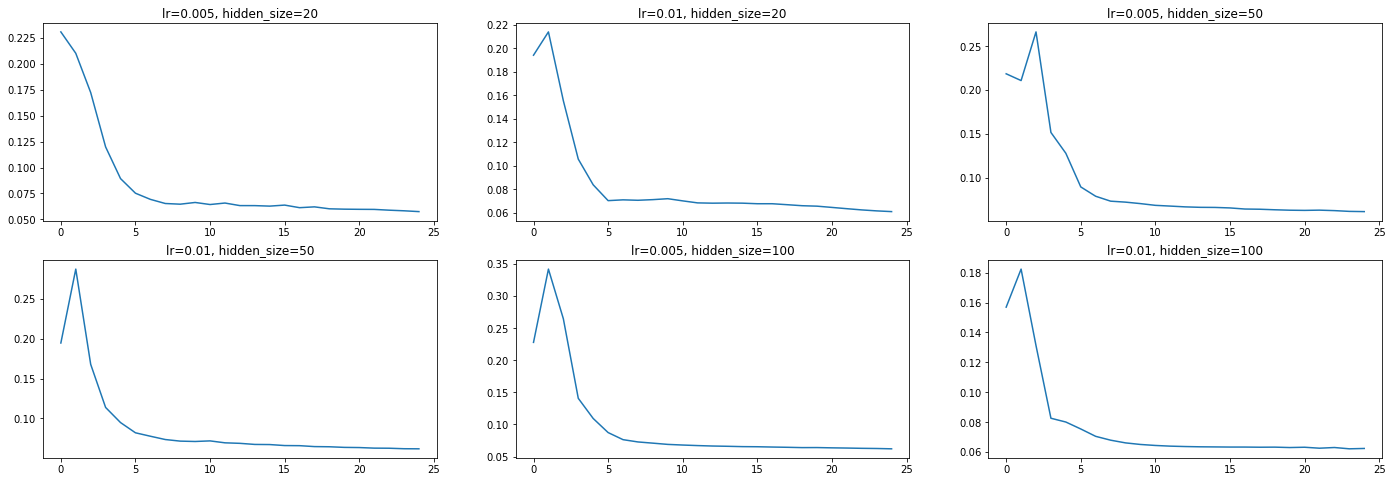

In [129]:
df_path_name = models_folder + '/df_desazon_pad'
data = {'df_val_norm': df_val_norm, 'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val,
        'y_val_date': y_val_date, 'train_loader':train_loader, 'val_loader':val_loader}

train_eval.training_and_tuning(data,
                    epochs=25,
                    min_epoch_eval=18,
                    df_path_name=df_path_name,
                    params_grid=params_grid)

In [131]:
def denorm(df_test,y_test_pred, y_test_date, *args):
    my_args = args[0]

    df_test_pred = mp.pred_to_dataframe(y_test_pred, y_test_date)
    df_test_pred  = rv.add_sazon_pad(df_test_pred, my_args['week_test_mean'], my_args['week_test_std'], 'week')
    df_test_pred  = rv.add_sazon_pad(df_test_pred , my_args['year_test_mean'], my_args['year_test_std'], 'year')

    return df_test_pred

In [133]:
# best model parameters
n1 = 20
lr = 0.005

df_path_name = models_folder + '/df_desazon_pad'
data = {'df_test': df_test, 'x_test': x_test, 'y_test': y_test, 'y_test_date': y_test_date, 'df_test_norm': df_test_norm, 'df_val_norm': df_val_norm,
        'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader':train_loader, 'val_loader': val_loader}
denorm_kwargs = {'week_test_mean': week_test_mean, 'week_test_std': week_test_std,'year_test_mean': year_test_mean, 'year_test_std': year_test_std}

# Run eval
best_model, metrics_dict, df_denorm_test_pred = train_eval.multiple_eval(n1, lr, data,
                                                             epochs=25,
                                                             df_path_name=df_path_name,
                                                             n_eval=20,
                                                             denorm=denorm,
                                                             min_epoch_eval=18,
                                                             verbose=True,
                                                             denorm_kwargs=denorm_kwargs)

Treino = 0, Test MAPE = 0.019703961584091732
Treino = 1, Test MAPE = 0.018759201265354353
Treino = 2, Test MAPE = 0.01856678691836444
Treino = 3, Test MAPE = 0.019335987409031842
Treino = 4, Test MAPE = 0.019259393005443947
Treino = 5, Test MAPE = 0.018899207052254268
Treino = 6, Test MAPE = 0.01914142100450653
Treino = 7, Test MAPE = 0.018774595665350127
Treino = 8, Test MAPE = 0.019025141951046876
Treino = 9, Test MAPE = 0.018724757142446587
Treino = 10, Test MAPE = 0.019572324298090943
Treino = 11, Test MAPE = 0.019415476027823276
Treino = 12, Test MAPE = 0.019247100377685497
Treino = 13, Test MAPE = 0.019442284658741857
Treino = 14, Test MAPE = 0.019637816103669513
Treino = 15, Test MAPE = 0.01889354663255032
Treino = 16, Test MAPE = 0.019378379143898224
Treino = 17, Test MAPE = 0.018867265192892883
Treino = 18, Test MAPE = 0.019079937094973253
Treino = 19, Test MAPE = 0.019330938974970565


Test
{'mse': 1193309.4788379879, 'mape': 0.019330938974970565}


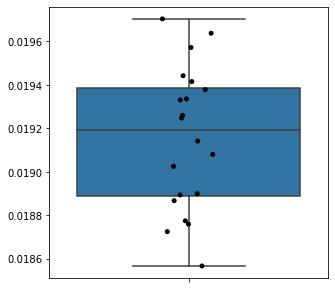

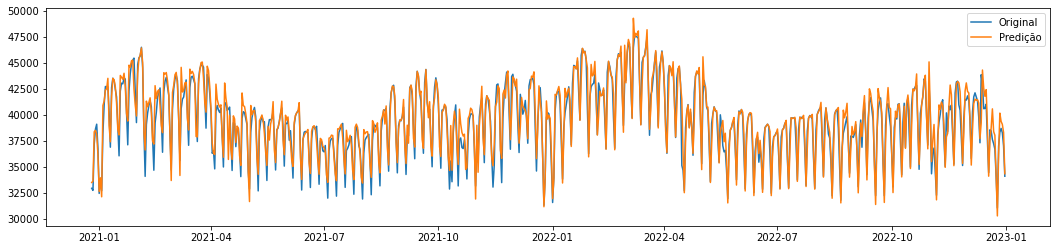

In [134]:
save_results(results_folder + '/df_desazon_pad', metrics_dict, df_denorm_test_pred, best_model)

mp.compare_predictions(df_test, df_denorm_test_pred)
print('Test')
print(mp.calc_metrics(df_test, df_denorm_test_pred))

## 6 - Original series without seasonality by moving average

In [135]:
data = pd.read_pickle('processed_curves/df_sudeste.pkl')

df_test_ma, month_test_mean = ts.season_MA(df_test, 'month')
df_train_ma, month_train_mean = ts.season_MA(df_train, 'month')
df_val_ma, month_val_mean = ts.season_MA(df_val, 'month')
data_ma, month_data_mean = ts.season_MA(data, 'month')
df_test_ma, weekday_test_mean = ts.season_MA(df_test_ma, 'weekday')
df_train_ma, weekday_train_mean = ts.season_MA(df_train_ma, 'weekday')
df_val_ma, weekday_val_mean = ts.season_MA(df_val_ma, 'weekday')
data_ma, weekday_data_mean = ts.season_MA(data_ma, 'weekday')

df_test_norm = ts.normalize(df_test_ma)
df_train_norm = ts.normalize(df_train_ma)
df_val_norm = ts.normalize(df_val_ma)
data_norm = ts.normalize(data_ma)

x_train, y_train, y_train_date, train_loader = prepare_dataset(df_train_norm, 30)
x_test, y_test, y_test_date,  test_loader =  prepare_dataset(df_test_norm, 30)
x_val, y_val, y_val_date, val_loader = prepare_dataset(df_val_norm, 30)

lr = 0.005, hidden_size = 20, min val mse epoch = 18, min val MSE = 0.4772844596035095, min val MAPE = 0
lr = 0.01, hidden_size = 20, min val mse epoch = 18, min val MSE = 0.6216510944917127, min val MAPE = 0
lr = 0.005, hidden_size = 50, min val mse epoch = 18, min val MSE = 0.5063200789678892, min val MAPE = 0
lr = 0.01, hidden_size = 50, min val mse epoch = 25, min val MSE = 0.5374006944924555, min val MAPE = 0
lr = 0.005, hidden_size = 100, min val mse epoch = 22, min val MSE = 0.42928810455673194, min val MAPE = 0
lr = 0.01, hidden_size = 100, min val mse epoch = 23, min val MSE = 0.745717287775075, min val MAPE = 0


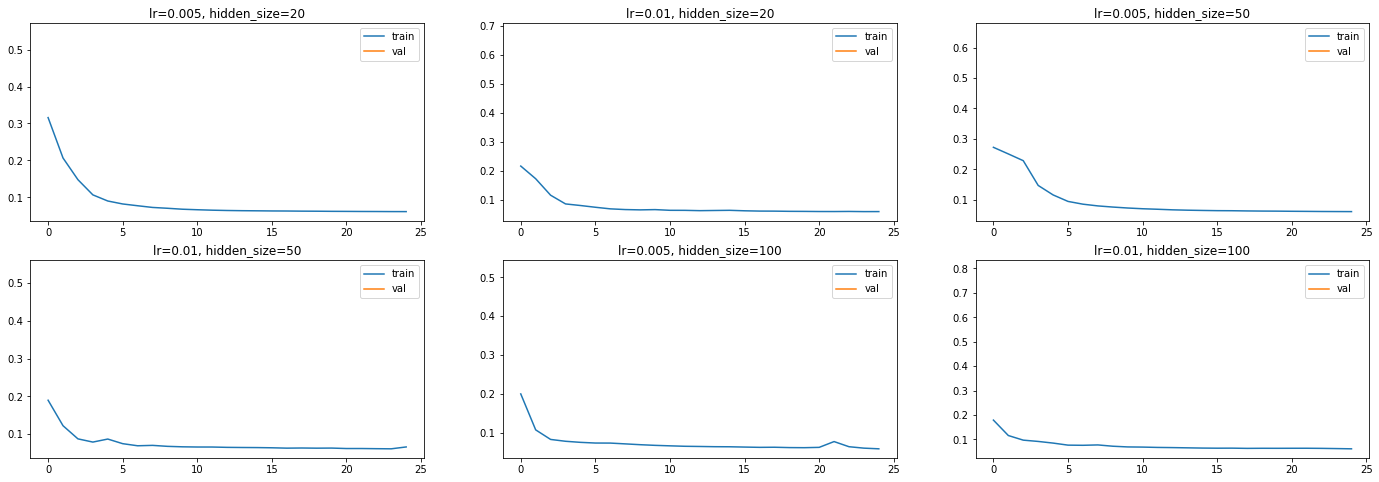

In [139]:
df_path_name = models_folder + '/df_desazon_MA'
data = {'df_val_norm': df_val_norm, 'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 
        'y_val_date': y_val_date, 'train_loader':train_loader, 'val_loader':val_loader}

train_eval.training_and_tuning(data,
                    epochs=25,
                    min_epoch_eval=18,
                    df_path_name=df_path_name,
                    params_grid=params_grid)

In [141]:
def denorm(df_test, y_test_pred, y_test_date, *args):
    my_args = args[0]

    df_test_pred = mp.pred_to_dataframe(y_test_pred, y_test_date)
    df_test_pred = rv.reverse_norm(my_args['df_test_ma'], df_test_pred)
    df_test_pred = rv.add_sazon_MA(df_test_pred, my_args['weekday_test_mean'], 'weekday')
    df_test_pred= rv.add_sazon_MA(df_test_pred, my_args['month_test_mean'], 'month')

    return df_test_pred

In [143]:
# best model parameters
n1 = 100
lr = 0.005

df_path_name = models_folder + '/df_desazon_MA'
data = {'df_test': df_test, 'x_test': x_test, 'y_test': y_test, 'y_test_date': y_test_date, 'df_test_norm': df_test_norm, 'df_val_norm': df_val_norm,
        'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader': train_loader, 'val_loader': val_loader}
denorm_kwargs = {'df_test_ma': df_test_ma, 'weekday_test_mean': weekday_test_mean, 'month_test_mean': month_test_mean}

# Run eval
best_model, metrics_dict, df_denorm_test_pred = train_eval.multiple_eval(n1, lr, data,
                                                             epochs=25,
                                                             df_path_name=df_path_name,
                                                             n_eval=20,
                                                             denorm=denorm,
                                                             min_epoch_eval=18,
                                                             verbose=True,
                                                             denorm_kwargs=denorm_kwargs)

Treino = 0, Test MAPE = 0.026686697179070844
Treino = 1, Test MAPE = 0.027418388974873215
Treino = 2, Test MAPE = 0.02561687218843167
Treino = 3, Test MAPE = 0.027590242743742915
Treino = 4, Test MAPE = 0.026732574342925457
Treino = 5, Test MAPE = 0.02244487320417014
Treino = 6, Test MAPE = 0.024058516747811363
Treino = 7, Test MAPE = 0.02712384184693194
Treino = 8, Test MAPE = 0.026876193370428497
Treino = 9, Test MAPE = 0.02942495547499238
Treino = 10, Test MAPE = 0.026580189233905618
Treino = 11, Test MAPE = 0.02594052722535853
Treino = 12, Test MAPE = 0.028882854536488166
Treino = 13, Test MAPE = 0.02597490370399156
Treino = 14, Test MAPE = 0.02790275125332072
Treino = 15, Test MAPE = 0.027702274057789526
Treino = 16, Test MAPE = 0.02765123999994728
Treino = 17, Test MAPE = 0.02996627214555631
Treino = 18, Test MAPE = 0.024890466020046707
Treino = 19, Test MAPE = 0.025131951568105704


Test
{'mse': 2210504.2410302134, 'mape': 0.025131951568105704}


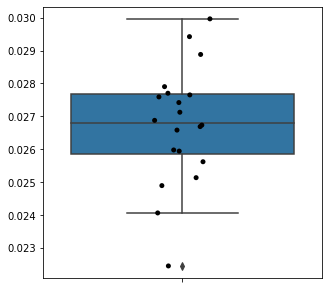

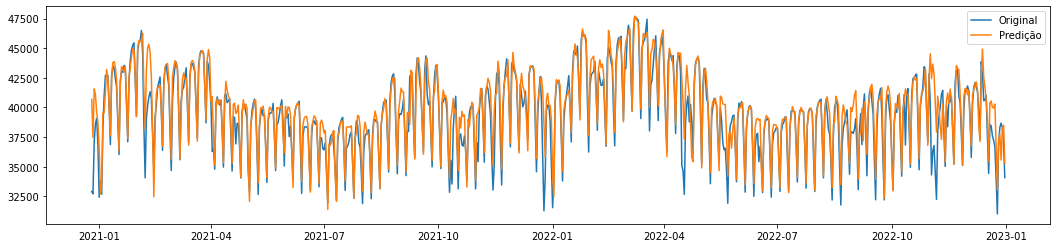

In [144]:
save_results(results_folder + '/df_desazon_MA', metrics_dict, df_denorm_test_pred, best_model)

mp.compare_predictions(df_test, df_denorm_test_pred)
print('Test')
print(mp.calc_metrics(df_test, df_denorm_test_pred))

## 8 - Original series without trend by curve fitting and without seasonality by normalization

In [15]:
data = pd.read_pickle('processed_curves/df_sudeste.pkl')

df_test_norm, coefs_test = ts.trend_fit_curve(df_test)
df_train_norm, coefs_train = ts.trend_fit_curve(df_train)
df_val_norm, coefs_val = ts.trend_fit_curve(df_val)
data_norm, coefs_data = ts.trend_fit_curve(data)

df_test_norm, year_test_mean, year_test_std = ts.season_padronization(df_test_norm, 'year')
df_train_norm, year_train_mean, year_train_std = ts.season_padronization(df_train_norm, 'year')
df_val_norm, year_val_mean, year_val_std = ts.season_padronization(df_val_norm, 'year')
data_norm, year_data_mean, year_data_std = ts.season_padronization(data_norm, 'year')

df_test_norm, week_test_mean, week_test_std = ts.season_padronization(df_test_norm, 'week')
df_train_norm, week_train_mean, week_train_std = ts.season_padronization(df_train_norm, 'week')
df_val_norm, week_val_mean, week_val_std = ts.season_padronization(df_val_norm, 'week')
data_norm, week_data_mean, week_data_std = ts.season_padronization(data_norm, 'week')


x_train, y_train, y_train_date, train_loader = prepare_dataset(df_train_norm, 30)
x_test, y_test, y_test_date,  test_loader =  prepare_dataset(df_test_norm, 30)
x_val, y_val, y_val_date, val_loader = prepare_dataset(df_val_norm, 30)

lr = 0.005, hidden_size = 20, min val mse epoch = 49, min val MSE = 0.8466555891078381, min val MAPE = 0
lr = 0.01, hidden_size = 20, min val mse epoch = 45, min val MSE = 0.8750913920179336, min val MAPE = 0
lr = 0.005, hidden_size = 50, min val mse epoch = 49, min val MSE = 0.8930418910312915, min val MAPE = 0
lr = 0.01, hidden_size = 50, min val mse epoch = 50, min val MSE = 0.8948591366273391, min val MAPE = 0
lr = 0.005, hidden_size = 100, min val mse epoch = 49, min val MSE = 0.858518148294754, min val MAPE = 0
lr = 0.01, hidden_size = 100, min val mse epoch = 50, min val MSE = 0.9053299450779393, min val MAPE = 0


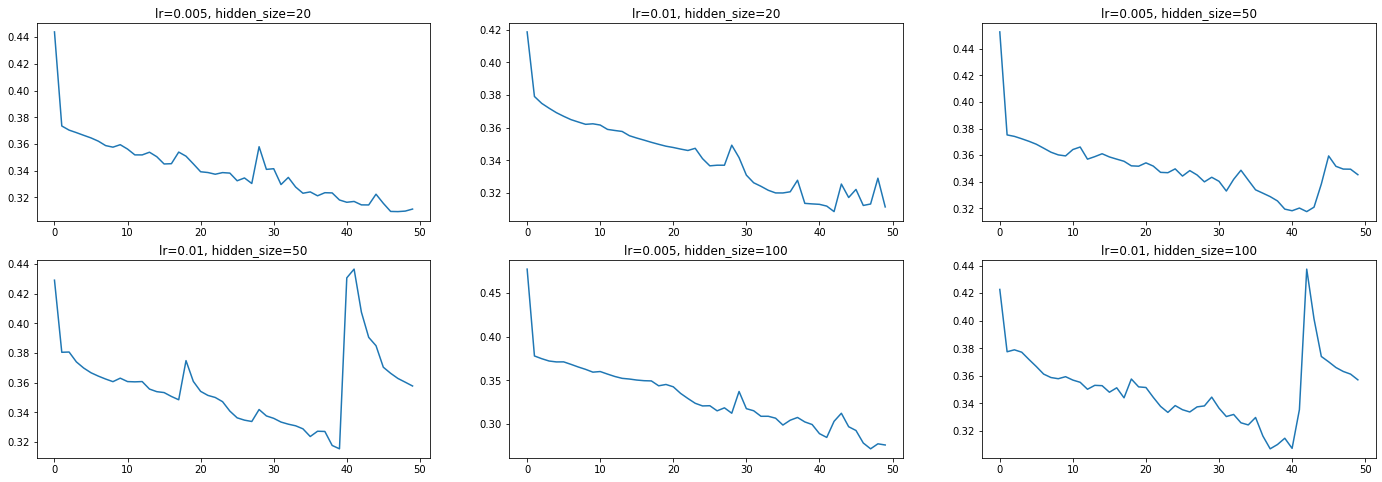

In [148]:
df_path_name = models_folder + '/df_fit_pad'
data = {'df_val_norm': df_val_norm, 'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader':train_loader, 'val_loader':val_loader}


train_eval.training_and_tuning(data,
                    epochs=50,
                    min_epoch_eval=45,
                    df_path_name=df_path_name,
                    params_grid=params_grid)

In [13]:
def denorm(df_test, y_test_pred, y_test_date, *args):
    my_args = args[0]

    df_test_pred = mp.pred_to_dataframe(y_test_pred, y_test_date)
    df_test_pred = rv.add_sazon_pad(df_test_pred, my_args['week_test_mean'], my_args['week_test_std'], 'week')
    df_test_pred = rv.add_sazon_pad(df_test_pred, my_args['year_test_mean'], my_args['year_test_std'], 'year')
    df_test_pred = rv.reverse_trend_fit(df_test_pred, my_args['coefs_test'])

    return df_test_pred

In [16]:
# best model parameters
n1 = 20
lr = 0.005

df_path_name = models_folder + '/df_fit_pad'
data = {'df_test': df_test, 'x_test': x_test, 'y_test': y_test, 'y_test_date': y_test_date, 'df_test_norm': df_test_norm, 'df_val_norm': df_val_norm,
        'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader': train_loader, 'val_loader':val_loader}
denorm_kwargs = {'week_test_mean': week_test_mean, 'week_test_std': week_test_std, 'year_test_mean': year_test_mean, 'year_test_std': year_test_std, \
                    'coefs_test': coefs_test}

# Run eval
best_model, metrics_dict, df_denorm_test_pred = train_eval.multiple_eval(n1, lr, data,
                                                             epochs=55,
                                                             df_path_name=df_path_name,
                                                             n_eval=20,
                                                             denorm=denorm,
                                                             min_epoch_eval=45,
                                                             verbose=True,
                                                             denorm_kwargs=denorm_kwargs)

Treino = 0, Test MAPE = 0.02151590808278133
Treino = 1, Test MAPE = 0.021064258837418498
Treino = 2, Test MAPE = 0.021313627379921204
Treino = 3, Test MAPE = 0.02179786295220789
Treino = 4, Test MAPE = 0.021368239454289784
Treino = 5, Test MAPE = 0.022078082686582373
Treino = 6, Test MAPE = 0.021889249838652012
Treino = 7, Test MAPE = 0.021552069102639862
Treino = 8, Test MAPE = 0.022550386455007003
Treino = 9, Test MAPE = 0.0221721623046607
Treino = 10, Test MAPE = 0.021600309994357882
Treino = 11, Test MAPE = 0.022997483914588963
Treino = 12, Test MAPE = 0.021842456395067517
Treino = 13, Test MAPE = 0.021161621494267372
Treino = 14, Test MAPE = 0.02146019037404643
Treino = 15, Test MAPE = 0.021580510780758757
Treino = 16, Test MAPE = 0.02155076173726603
Treino = 17, Test MAPE = 0.022248665394524553
Treino = 18, Test MAPE = 0.021362991338579905
Treino = 19, Test MAPE = 0.021257775910554576


Test
{'mse': 1357182.050394876, 'mape': 0.021257775910554576}


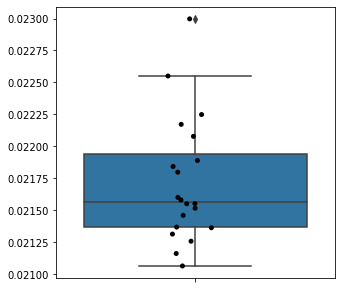

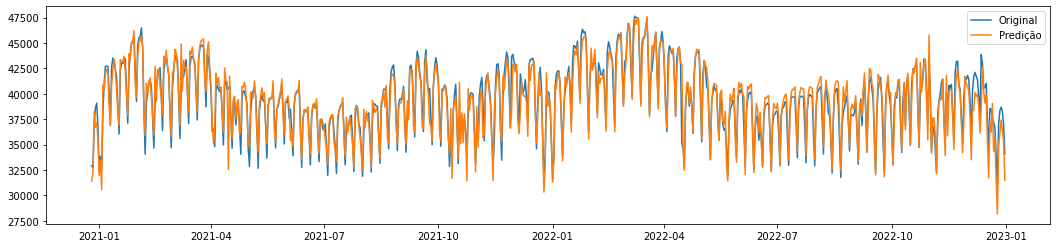

In [17]:
save_results(results_folder + '/df_fit_pad', metrics_dict, df_denorm_test_pred, best_model)

mp.compare_predictions(df_test, df_denorm_test_pred)
print('Test')
print(mp.calc_metrics(df_test, df_denorm_test_pred))

## 9 - Original series without trend by curve fitting and without seasonality by moving avegrage

In [18]:
data = pd.read_pickle('processed_curves/df_sudeste.pkl')

df_test_fit, coefs_test = ts.trend_fit_curve(df_test)
df_train_fit, coefs_train = ts.trend_fit_curve(df_train)
df_val_fit, coefs_val = ts.trend_fit_curve(df_val)
data_fit, coefs_train_val = ts.trend_fit_curve(data)


df_test_ma, month_test_mean = ts.season_MA(df_test_fit, 'month')
df_train_ma, month_train_mean = ts.season_MA(df_train_fit, 'month')
df_val_ma, month_val_mean = ts.season_MA(df_val_fit, 'month')
data_ma, month_data_mean = ts.season_MA(data_fit, 'month')

df_test_ma, weekday_test_mean = ts.season_MA(df_test_ma, 'weekday')
df_train_ma, weekday_train_mean = ts.season_MA(df_train_ma, 'weekday')
df_val_ma, weekday_val_mean = ts.season_MA(df_val_ma, 'weekday')
data_ma, weekday_data_mean = ts.season_MA(data_ma, 'weekday')


df_test_norm = ts.normalize(df_test_ma)
df_train_norm = ts.normalize(df_train_ma)
df_val_norm = ts.normalize(df_val_ma)
data_norm = ts.normalize(data_ma)


x_train, y_train, y_train_date, train_loader = prepare_dataset(df_train_norm, 30)
x_test, y_test, y_test_date,  test_loader =  prepare_dataset(df_test_norm, 30)
x_val, y_val, y_val_date, val_loader = prepare_dataset(df_val_norm, 30)

lr = 0.005, hidden_size = 20, min val mse epoch = 75, min val MSE = 0.3177142038867604, min val MAPE = 0
lr = 0.01, hidden_size = 20, min val mse epoch = 78, min val MSE = 0.32153356148522066, min val MAPE = 0
lr = 0.005, hidden_size = 50, min val mse epoch = 75, min val MSE = 0.3539645650959457, min val MAPE = 0
lr = 0.01, hidden_size = 50, min val mse epoch = 80, min val MSE = 0.3088460196698918, min val MAPE = 0
lr = 0.005, hidden_size = 100, min val mse epoch = 78, min val MSE = 0.37429384190884923, min val MAPE = 0
lr = 0.01, hidden_size = 100, min val mse epoch = 75, min val MSE = 0.46144972589559474, min val MAPE = 0


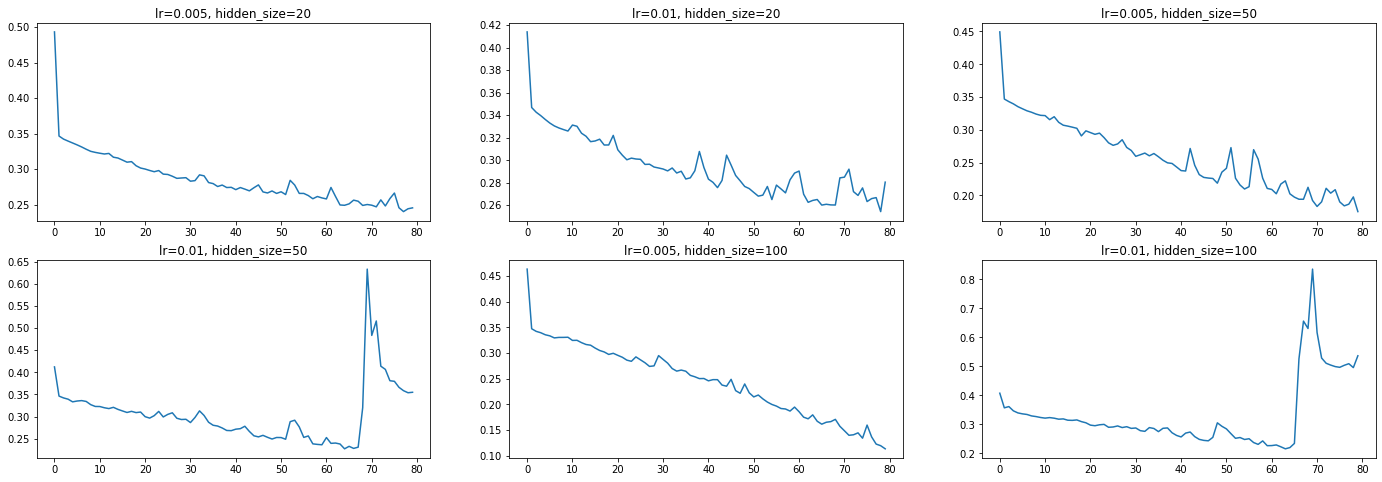

In [22]:
df_path_name=models_folder + '/df_fit_MA'
data = {'df_val_norm': df_val_norm, 'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader':train_loader, 'val_loader':val_loader}

train_eval.training_and_tuning(data,
                    epochs=80,
                    min_epoch_eval=75,
                    df_path_name=df_path_name,
                    params_grid=params_grid)

In [23]:
def denorm(df_test, y_test_pred, y_test_date, *args):
    my_args = args[0]

    df_test_pred = mp.pred_to_dataframe(y_test_pred, y_test_date)
    df_test_pred = rv.reverse_norm(my_args['df_test_ma'], df_test_pred)
    df_test_pred = rv.add_sazon_MA(df_test_pred, my_args['weekday_test_mean'], 'weekday')
    df_test_pred = rv.add_sazon_MA(df_test_pred, my_args['month_test_mean'], 'month')
    df_test_pred = rv.reverse_trend_fit(df_test_pred, my_args['coefs_test'])

    return df_test_pred

In [24]:
# best model parameters
n1 = 20
lr = 0.005

df_path_name = models_folder + '/df_fit_MA'
data = {'df_test': df_test, 'x_test': x_test, 'y_test': y_test, 'y_test_date': y_test_date, 'df_test_norm': df_test_norm, 'df_val_norm': df_val_norm,
        'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader':train_loader, 'val_loader':val_loader}
denorm_kwargs = {'df_test_ma': df_test_ma, 'weekday_test_mean': weekday_test_mean, 'month_test_mean': month_test_mean, \
                   'coefs_test': coefs_test, 'coefs_train': coefs_train_val}

# Run eval
best_model, metrics_dict, df_denorm_test_pred = train_eval.multiple_eval(n1, lr, data,
                                                             epochs=60,
                                                             df_path_name=df_path_name,
                                                             n_eval=20,
                                                             denorm=denorm,
                                                             min_epoch_eval=50,
                                                             verbose=True,
                                                             denorm_kwargs=denorm_kwargs)

Treino = 0, Test MAPE = 0.02126753979607808
Treino = 1, Test MAPE = 0.02332214820803807
Treino = 2, Test MAPE = 0.02218104781558167
Treino = 3, Test MAPE = 0.02188859740314735
Treino = 4, Test MAPE = 0.02166053603841643
Treino = 5, Test MAPE = 0.021768295154773715
Treino = 6, Test MAPE = 0.021471368727444876
Treino = 7, Test MAPE = 0.02234811721666036
Treino = 8, Test MAPE = 0.021543822582868875
Treino = 9, Test MAPE = 0.02102746010923784
Treino = 10, Test MAPE = 0.021254303226159333
Treino = 11, Test MAPE = 0.021447106009502247
Treino = 12, Test MAPE = 0.022191820567607653
Treino = 13, Test MAPE = 0.021555054703270935
Treino = 14, Test MAPE = 0.02166920362923134
Treino = 15, Test MAPE = 0.022061927007779095
Treino = 16, Test MAPE = 0.022746246706915753
Treino = 17, Test MAPE = 0.023111621284369572
Treino = 18, Test MAPE = 0.021354745540791805
Treino = 19, Test MAPE = 0.022383889090662405


Test
{'mse': 1444731.3231405003, 'mape': 0.022383889090662405}


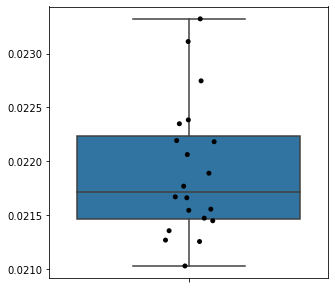

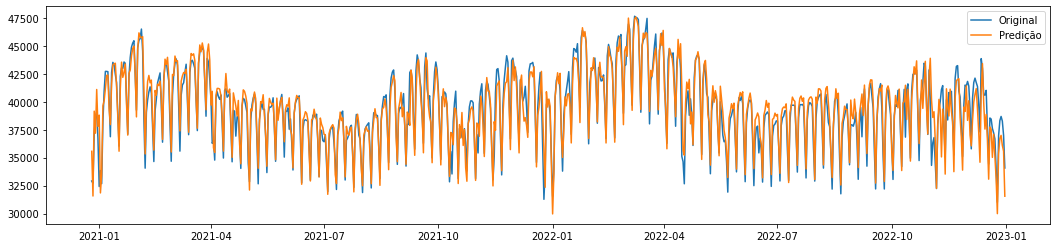

In [25]:
save_results(results_folder + '/df_fit_MA', metrics_dict, df_denorm_test_pred, best_model)

mp.compare_predictions(df_test, df_denorm_test_pred)
print('Test')
print(mp.calc_metrics(df_test, df_denorm_test_pred))

## 10 - Original Series without trend by differencing and without seasonality by normalization

In [26]:
data = pd.read_pickle('processed_curves/df_sudeste.pkl')

df_test_diff = ts.trend_diff(df_test)
df_train_diff = ts.trend_diff(df_train)
df_val_diff = ts.trend_diff(df_val)
data_diff = ts.trend_diff(data)

df_test_norm, year_test_mean, year_test_std = ts.season_padronization(df_test_diff, 'year')
df_train_norm, year_train_mean, year_train_std = ts.season_padronization(df_train_diff, 'year')
df_val_norm, year_val_mean, year_val_std = ts.season_padronization(df_val_diff, 'year')
data_norm, year_data_mean, year_data_std = ts.season_padronization(data_diff, 'year')


df_test_norm, week_test_mean, week_test_std = ts.season_padronization(df_test_norm, 'week')
df_train_norm, week_train_mean, week_train_std = ts.season_padronization(df_train_norm, 'week')
df_val_norm, week_val_mean, week_val_std = ts.season_padronization(df_val_norm, 'week')
data_norm, week_data_mean, week_data_std = ts.season_padronization(data_norm, 'week')

x_train, y_train, y_train_date, train_loader = prepare_dataset(df_train_norm, 30)
x_test, y_test, y_test_date,  test_loader =  prepare_dataset(df_test_norm, 30)
x_val, y_val, y_val_date, val_loader = prepare_dataset(df_val_norm, 30)

In [27]:
def denorm(df_test,y_test_pred, y_test_date, *args):
    my_args = args[0]

    df_test_pred = mp.pred_to_dataframe(y_test_pred, y_test_date)
    df_test_pred = rv.add_sazon_pad(df_test_pred, my_args['week_test_mean'], my_args['week_test_std'], 'week')
    df_test_pred = rv.add_sazon_pad(df_test_pred, my_args['year_test_mean'], my_args['year_test_std'], 'year')
    df_test_pred = rv.reverse_trend_diff(my_args['df_test'], df_test_pred)

    return df_test_pred

lr = 0.005, hidden_size = 20, min val mse epoch = 85, min val MSE = 1.245967571124316, min val MAPE = 0
lr = 0.01, hidden_size = 20, min val mse epoch = 86, min val MSE = 0.929545613873229, min val MAPE = 0
lr = 0.005, hidden_size = 50, min val mse epoch = 85, min val MSE = 1.3070596341366687, min val MAPE = 0
lr = 0.01, hidden_size = 50, min val mse epoch = 90, min val MSE = 1.0251323764906397, min val MAPE = 0
lr = 0.005, hidden_size = 100, min val mse epoch = 86, min val MSE = 1.3222269275070127, min val MAPE = 0
lr = 0.01, hidden_size = 100, min val mse epoch = 88, min val MSE = 1.173789468265467, min val MAPE = 0


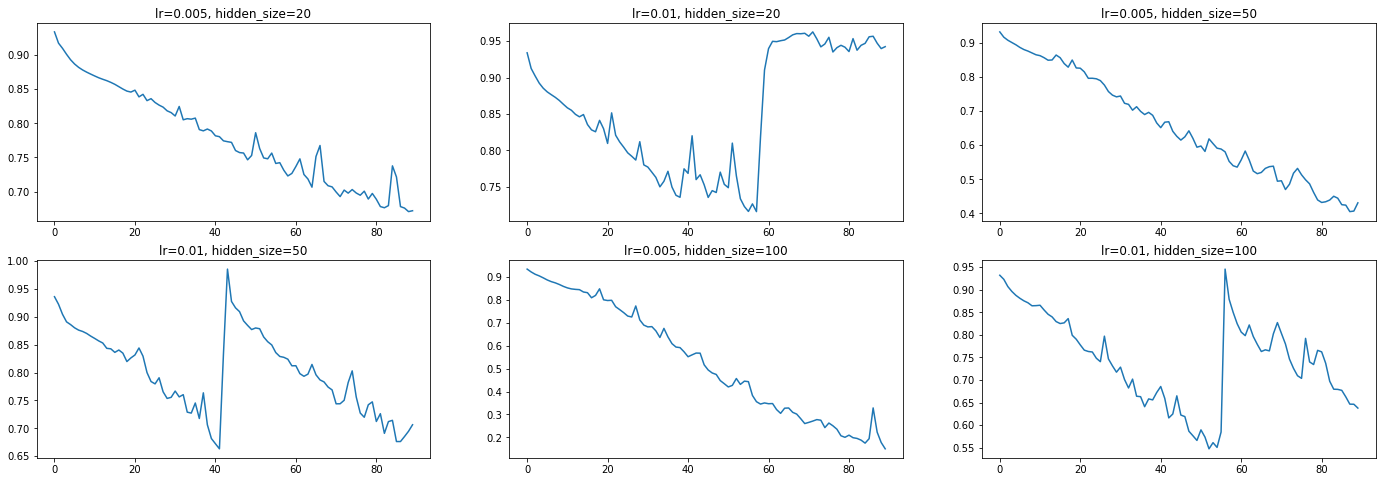

In [29]:
df_path_name=models_folder + '/df_diff_pad'
data = {'df_val_norm': df_val_norm, 'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader':train_loader, 'val_loader':val_loader}

train_eval.training_and_tuning(data,
                    epochs=90,
                    min_epoch_eval=85,
                    df_path_name=df_path_name,
                    params_grid=params_grid)

In [33]:
# best model parameters
n1 = 100
lr = 0.005

df_path_name = models_folder + '/df_diff_pad'
data = {'df_test': df_test, 'x_test': x_test, 'y_test': y_test, 'y_test_date': y_test_date, 'df_test_norm': df_test_norm, 'df_val_norm': df_val_norm,
        'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader':train_loader, 'val_loader':val_loader}
denorm_kwargs = {'df_test': df_test, 'df_train': df_train_val, 'week_test_mean': week_test_mean, 'week_test_std': week_test_std, \
                   'year_test_mean': year_test_mean, 'year_test_std': year_test_std}

# Run eval
best_model, metrics_dict, df_denorm_test_pred = train_eval.multiple_eval(n1, lr, data,
                                                             epochs=50,
                                                             df_path_name=df_path_name,
                                                             n_eval=20,
                                                             denorm=denorm,
                                                             min_epoch_eval=45,
                                                             verbose=True,
                                                             denorm_kwargs=denorm_kwargs)

Treino = 0, Test MAPE = 0.022191728882064755
Treino = 1, Test MAPE = 0.019567054309075717
Treino = 2, Test MAPE = 0.021485480683900108
Treino = 3, Test MAPE = 0.01868355746467743
Treino = 4, Test MAPE = 0.022435450860082376
Treino = 5, Test MAPE = 0.02072843794528629
Treino = 6, Test MAPE = 0.02095985828290643
Treino = 7, Test MAPE = 0.021590647543660454
Treino = 8, Test MAPE = 0.018273169439879507
Treino = 9, Test MAPE = 0.020617620301029333
Treino = 10, Test MAPE = 0.021646887009322727
Treino = 11, Test MAPE = 0.0198660259692241
Treino = 12, Test MAPE = 0.02143483481420563
Treino = 13, Test MAPE = 0.020531186781564934
Treino = 14, Test MAPE = 0.021654541887021823
Treino = 15, Test MAPE = 0.020528059465683122
Treino = 16, Test MAPE = 0.01928626777945821
Treino = 17, Test MAPE = 0.01671204959634248
Treino = 18, Test MAPE = 0.019390716951874533
Treino = 19, Test MAPE = 0.016389732102233653


Test
{'mse': 869317.7038516888, 'mape': 0.016389732102233653}


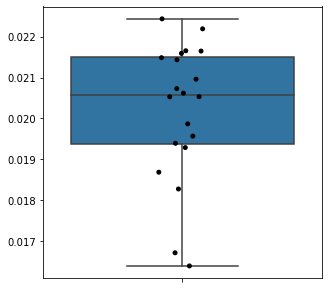

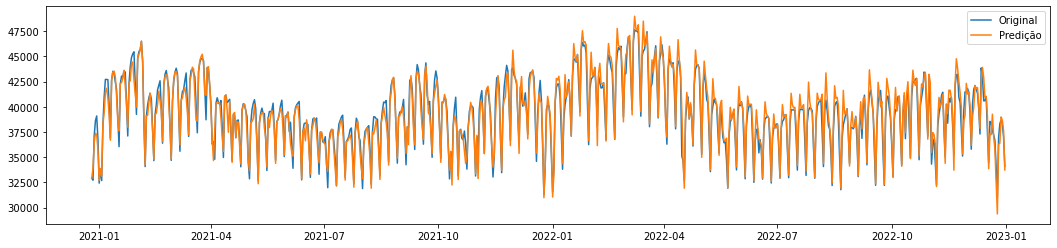

In [34]:
save_results(results_folder + '/df_diff_pad', metrics_dict, df_denorm_test_pred, best_model)

mp.compare_predictions(df_test, df_denorm_test_pred)
print('Test')
print(mp.calc_metrics(df_test, df_denorm_test_pred))

## 11 - Original series without trend by differencing and without seasonality by moving average

In [35]:
data = pd.read_pickle('processed_curves/df_sudeste.pkl')

df_test_diff = ts.trend_diff(df_test)
df_train_diff = ts.trend_diff(df_train)
df_val_diff = ts.trend_diff(df_val)
data_diff = ts.trend_diff(data)

df_test_ma, month_test_mean = ts.season_MA(df_test_diff, 'month')
df_train_ma, month_train_mean = ts.season_MA(df_train_diff, 'month')
df_val_ma, month_val_mean = ts.season_MA(df_val_diff, 'month')
data_ma, month_data_mean = ts.season_MA(data_diff, 'month')

df_test_ma, weekday_test_mean = ts.season_MA(df_test_ma, 'weekday')
df_train_ma, weekday_train_mean = ts.season_MA(df_train_ma, 'weekday')
df_val_ma, weekday_val_mean = ts.season_MA(df_val_ma, 'weekday')
data_ma, weekday_data_mean = ts.season_MA(data_ma, 'weekday')

df_test_norm = ts.normalize(df_test_ma)
df_train_norm = ts.normalize(df_train_ma)
df_val_norm = ts.normalize(df_val_ma)
data_norm = ts.normalize(data_ma)

x_train, y_train, y_train_date, train_loader = prepare_dataset(df_train_norm, 30)
x_test, y_test, y_test_date,  test_loader =  prepare_dataset(df_test_norm, 30)
x_val, y_val, y_val_date, val_loader = prepare_dataset(df_val_norm, 30)

lr = 0.005, hidden_size = 20, min val mse epoch = 55, min val MSE = 0.9367929135224636, min val MAPE = 0
lr = 0.01, hidden_size = 20, min val mse epoch = 55, min val MSE = 0.908549211924525, min val MAPE = 0
lr = 0.005, hidden_size = 50, min val mse epoch = 56, min val MSE = 1.168189155875854, min val MAPE = 0
lr = 0.01, hidden_size = 50, min val mse epoch = 57, min val MSE = 0.7823698851702959, min val MAPE = 0
lr = 0.005, hidden_size = 100, min val mse epoch = 60, min val MSE = 1.1672662987117846, min val MAPE = 0
lr = 0.01, hidden_size = 100, min val mse epoch = 55, min val MSE = 0.867567598005714, min val MAPE = 0


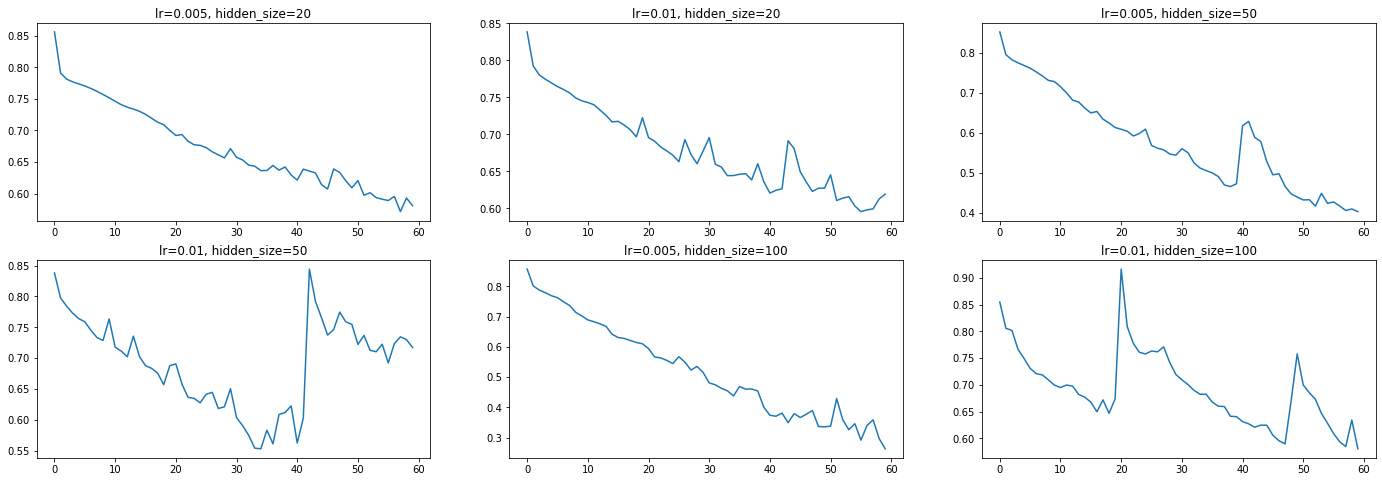

In [36]:
df_path_name=models_folder + '/df_diff_MA'
data = {'df_val_norm': df_val_norm, 'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader':train_loader, 'val_loader':val_loader}

train_eval.training_and_tuning(data,
                    epochs=60,
                    min_epoch_eval=55,
                    df_path_name=df_path_name,
                    params_grid=params_grid)

In [37]:
def denorm(df_test, y_test_pred, y_test_date, *args):
    my_args = args[0]

    df_test_pred = mp.pred_to_dataframe(y_test_pred, y_test_date)
    df_test_pred = rv.reverse_norm(my_args['df_test_ma'], df_test_pred)
    df_test_pred = rv.add_sazon_MA(df_test_pred, my_args['weekday_test_mean'], 'weekday')
    df_test_pred = rv.add_sazon_MA(df_test_pred, my_args['month_test_mean'], 'month')
    df_test_pred = rv.reverse_trend_diff(my_args['df_test'], df_test_pred)

    return df_test_pred

In [38]:
# best model parameters
n1 = 100
lr = 0.005

df_path_name = models_folder + '/df_diff_MA'
data = {'df_test': df_test, 'x_test': x_test, 'y_test': y_test, 'y_test_date': y_test_date, 'df_test_norm': df_test_norm, 'df_val_norm': df_val_norm,
        'x_train': x_train, 'y_train': y_train, 'y_train_date': y_train_date, 'x_val': x_val, 'y_val': y_val, 'y_val_date': y_val_date,
        'train_loader':train_loader,'val_loader':val_loader}
denorm_kwargs = {'df_test_ma': df_test_ma, 'weekday_test_mean': weekday_test_mean, 'month_test_mean': month_test_mean, \
                    'df_test': df_test, 'df_train': df_train_val}

# Run eval
best_model, metrics_dict, df_denorm_test_pred = train_eval.multiple_eval(n1, lr, data,
                                                             epochs=60,
                                                             df_path_name=df_path_name,
                                                             n_eval=20,
                                                             denorm=denorm,
                                                             min_epoch_eval=55,
                                                             verbose=True,
                                                             denorm_kwargs=denorm_kwargs)

Treino = 0, Test MAPE = 0.02031698494277485
Treino = 1, Test MAPE = 0.019519262157058508
Treino = 2, Test MAPE = 0.021562005224323545
Treino = 3, Test MAPE = 0.020658738190661788
Treino = 4, Test MAPE = 0.0193093540234582
Treino = 5, Test MAPE = 0.021124815273733232
Treino = 6, Test MAPE = 0.01983919104834109
Treino = 7, Test MAPE = 0.020569225763638385
Treino = 8, Test MAPE = 0.019696423976699066
Treino = 9, Test MAPE = 0.020648880267594566
Treino = 10, Test MAPE = 0.02106359366061328
Treino = 11, Test MAPE = 0.01999195940658546
Treino = 12, Test MAPE = 0.020985641507108143
Treino = 13, Test MAPE = 0.02021710026485904
Treino = 14, Test MAPE = 0.019717560287692608
Treino = 15, Test MAPE = 0.019852942991128594
Treino = 16, Test MAPE = 0.01811173996980859
Treino = 17, Test MAPE = 0.020536190831133515
Treino = 18, Test MAPE = 0.020436719480717395
Treino = 19, Test MAPE = 0.02009485364251325


Test
{'mse': 1407564.8195251753, 'mape': 0.02009485364251325}


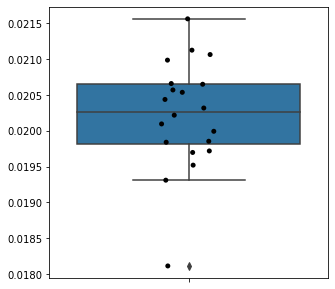

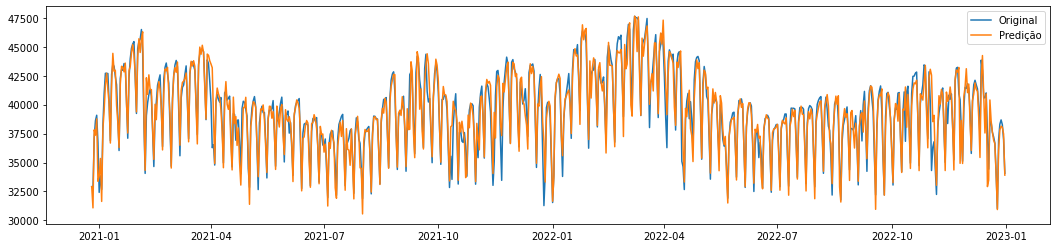

In [39]:
save_results(results_folder + '/df_diff_MA', metrics_dict, df_denorm_test_pred, best_model)

mp.compare_predictions(df_test, df_denorm_test_pred)
print('Test')
print(mp.calc_metrics(df_test, df_denorm_test_pred))

# Plotting

In [141]:
import os
import json

ts_id = {'df_norm': 1, 'df_fit_curve': 2, 'df_trend_diff': 3, 'df_desazon_MA': 4, 'df_desazon_pad': 5,
         'df_sudeste': 0, 'df_fit_MA': 6, 'df_fit_pad': 7, 'df_diff_MA': 8, 'df_diff_pad': 9}

df_mse = pd.DataFrame()
df_mape = pd.DataFrame()
for df_name in os.listdir(results_folder):
    with open(results_folder + f'/{df_name}/metrics.json') as jsonfile:
       dict_values = json.load(jsonfile)
       df_mse[ts_id[df_name]] = dict_values['mse_list']
       df_mape[ts_id[df_name]] = dict_values['mape_list']

df_mse = df_mse[range(1,10)]
df_mape = df_mape[range(1,10)]

In [143]:
from matplotlib import font_manager

# Register Times New Roman font
font_path = 'times.ttf'  # Replace with the actual path to the font file
font_manager.fontManager.addfont(font_path)

# Set font family to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

sns.set_style("whitegrid")

<AxesSubplot:title={'center':'MSE regarding each method for 20 simulations'}, xlabel='ID method', ylabel='MSE'>

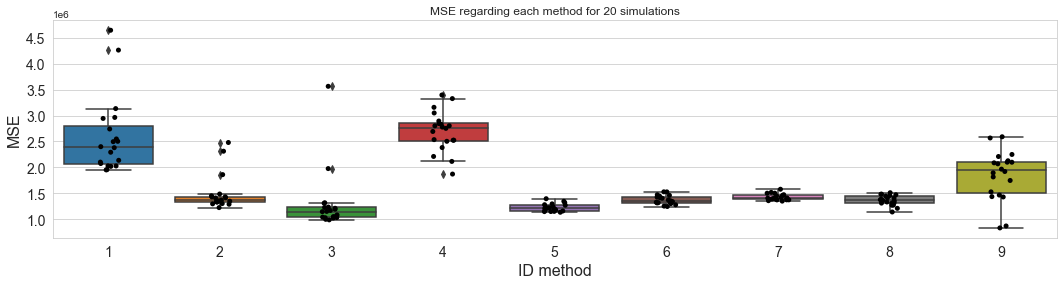

In [144]:
plt.figure(figsize=(18,4))
sns.boxplot(data=df_mse)
plt.xlabel('ID method', fontsize=16)
plt.ylabel('MSE', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('MSE regarding each method for 20 simulations')
sns.stripplot(data = df_mse, color = 'black')

<AxesSubplot:title={'center':'MAPE regarding each method for 20 simulations'}, xlabel='ID method', ylabel='MAPE'>

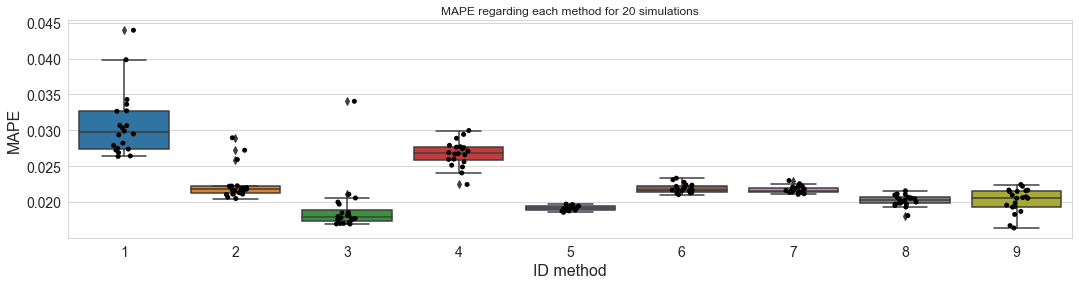

In [145]:
plt.figure(figsize=(18,4))
sns.boxplot(data=df_mape)
plt.xlabel('ID method', fontsize=16)
plt.ylabel('MAPE', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('MAPE regarding each method for 20 simulations')
sns.stripplot(data = df_mape, color = 'black')